In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
!pip -q install timm pandas scikit-learn tqdm


In [3]:
from pathlib import Path
import json, time, random
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms
from PIL import Image

import timm
from tqdm import tqdm

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt


In [4]:
PROJECT_ROOT = Path("/content/drive/MyDrive/SkinCare_AI_Component")

META_DIR = PROJECT_ROOT / "data/11_skin_type/metadata"
INDEX_CSV = META_DIR / "image_index_skin_type.csv"
LABEL_MAP_JSON = META_DIR / "label_map_skin_type.json"

OUT_MODELS  = PROJECT_ROOT / "models/vision"
OUT_METRICS = PROJECT_ROOT / "results/metrics"
OUT_CM      = PROJECT_ROOT / "results/confusion_matrices"

OUT_MODELS.mkdir(parents=True, exist_ok=True)
OUT_METRICS.mkdir(parents=True, exist_ok=True)
OUT_CM.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "swin_tiny_patch4_window7_224"  # ✅ Swin Transformer (non-CNN)

MODEL_OUT   = OUT_MODELS / "skin_type_swin_best.pt"
METRICS_OUT = OUT_METRICS / "skin_type_swin_metrics.json"
CM_OUT      = OUT_CM / "skin_type_swin_confusion_matrix_counts.png"
CM_PCT_OUT  = OUT_CM / "skin_type_swin_confusion_matrix_percent.png"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

assert INDEX_CSV.exists(), f"Missing: {INDEX_CSV}"
assert LABEL_MAP_JSON.exists(), f"Missing: {LABEL_MAP_JSON}"

df = pd.read_csv(INDEX_CSV)
with open(LABEL_MAP_JSON, "r") as f:
    label_map = json.load(f)

id_to_label = {v: k for k, v in label_map.items()}
num_classes = len(label_map)

print("✅ Classes:", label_map)
print("✅ Total samples:", len(df))
df.head()


Device: cuda
✅ Classes: {'oily': 0, 'dry': 1, 'combination': 2}
✅ Total samples: 7019


,image_path,label_name,label_id,split
0,data/11_skin_type/splits/test/oily/00705a62e3f...,oily,0,test
1,data/11_skin_type/splits/test/oily/0108b7638b1...,oily,0,test
2,data/11_skin_type/splits/test/oily/0108b7638b1...,oily,0,test
3,data/11_skin_type/splits/test/oily/0108b7638b1...,oily,0,test
4,data/11_skin_type/splits/test/oily/0108b7638b1...,oily,0,test


In [5]:
df_train = df[df["split"] == "train"].copy()
df_val   = df[df["split"] == "val"].copy()
df_test  = df[df["split"] == "test"].copy()

print("Split sizes:", len(df_train), len(df_val), len(df_test))
assert len(df_train) > 0 and len(df_val) > 0 and len(df_test) > 0, "❌ One split is empty."


Split sizes: 4978 1008 1033


In [6]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 12
LR = 1e-4
WEIGHT_DECAY = 1e-4
NUM_WORKERS = 2

IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD  = (0.229, 0.224, 0.225)

print("✅ Config loaded.")


✅ Config loaded.


In [7]:
train_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomApply([transforms.ColorJitter(0.15, 0.15, 0.10, 0.02)], p=0.6),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

eval_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

class SkinTypeDataset(Dataset):
    def __init__(self, df_, tfm):
        self.df = df_.reset_index(drop=True)
        self.tfm = tfm

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        r = self.df.iloc[idx]
        img = Image.open(PROJECT_ROOT / r["image_path"]).convert("RGB")
        x = self.tfm(img)
        y = int(r["label_id"])
        return x, y


In [8]:
train_loader = DataLoader(SkinTypeDataset(df_train, train_tfms),
                          batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=True)

val_loader = DataLoader(SkinTypeDataset(df_val, eval_tfms),
                        batch_size=BATCH_SIZE, shuffle=False,
                        num_workers=NUM_WORKERS, pin_memory=True)

test_loader = DataLoader(SkinTypeDataset(df_test, eval_tfms),
                         batch_size=BATCH_SIZE, shuffle=False,
                         num_workers=NUM_WORKERS, pin_memory=True)

print("✅ Loaders ready.")


✅ Loaders ready.


In [9]:
from collections import Counter

counts = Counter(df_train["label_id"].tolist())
print("Train counts:", {id_to_label[k]: v for k, v in sorted(counts.items())})

class_weights = np.array([1.0 / counts.get(i, 1) for i in range(num_classes)], dtype=np.float32)
class_weights = class_weights / class_weights.sum() * num_classes
cw = torch.tensor(class_weights, dtype=torch.float32).to(device)

print("Class weights:", {id_to_label[i]: float(class_weights[i]) for i in range(num_classes)})


Train counts: {'oily': 1764, 'dry': 2100, 'combination': 1114}
Class weights: {'oily': 0.876300573348999, 'dry': 0.7360924482345581, 'combination': 1.3876070976257324}


In [10]:
model = timm.create_model(MODEL_NAME, pretrained=True, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss(weight=cw, label_smoothing=0.05)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

total_steps = EPOCHS * len(train_loader)
warmup_steps = int(0.1 * total_steps)

def lr_lambda(step):
    if step < warmup_steps:
        return float(step) / float(max(1, warmup_steps))
    prog = float(step - warmup_steps) / float(max(1, total_steps - warmup_steps))
    return 0.5 * (1.0 + np.cos(np.pi * prog))

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)
scaler = torch.cuda.amp.GradScaler(enabled=(device.type=="cuda"))

print("✅ Model ready:", MODEL_NAME)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

✅ Model ready: swin_tiny_patch4_window7_224


/tmp/ipython-input-696092704.py:16: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.type=="cuda"))


In [11]:
def run_epoch(loader, train=True):
    model.train() if train else model.eval()
    total_loss, correct, total = 0.0, 0, 0

    for x, y in tqdm(loader, leave=False):
        x, y = x.to(device), y.to(device)
        if train:
            optimizer.zero_grad(set_to_none=True)

        with torch.set_grad_enabled(train):
            with torch.amp.autocast(device_type="cuda", enabled=(device.type=="cuda")):
                logits = model(x)
                loss = criterion(logits, y)

            if train:
                scaler.scale(loss).backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                scaler.step(optimizer)
                scaler.update()
                scheduler.step()

        total_loss += loss.item() * x.size(0)
        correct += (logits.argmax(1) == y).sum().item()
        total += x.size(0)

    return total_loss/max(total,1), correct/max(total,1)


In [12]:
best_val = 0.0
history = []
PATIENCE = 4
bad = 0

for epoch in range(1, EPOCHS + 1):
    t0 = time.time()

    tr_loss, tr_acc = run_epoch(train_loader, True)
    va_loss, va_acc = run_epoch(val_loader, False)

    history.append({
        "epoch": epoch,
        "train_loss": float(tr_loss),
        "train_acc": float(tr_acc),
        "val_loss": float(va_loss),
        "val_acc": float(va_acc),
        "seconds": float(time.time() - t0)
    })

    print(f"Epoch {epoch}/{EPOCHS} | train acc {tr_acc:.4f} | val acc {va_acc:.4f}")

    if va_acc > best_val:
        best_val = va_acc
        bad = 0
        torch.save({
            "model_state": model.state_dict(),
            "model_name": MODEL_NAME,
            "label_map": label_map,
            "img_size": IMG_SIZE
        }, MODEL_OUT)
        print("✅ Saved best:", MODEL_OUT, "val_acc:", best_val)
    else:
        bad += 1
        if bad >= PATIENCE:
            print(f"⏹️ Early stop. Best val={best_val:.4f}")
            break

print("✅ Training done. Best val acc:", best_val)


Epoch 1/12 | train acc 0.4681 | val acc 0.5298
✅ Saved best: /content/drive/MyDrive/SkinCare_AI_Component/models/vision/skin_type_swin_best.pt val_acc: 0.5297619047619048


Epoch 2/12 | train acc 0.6553 | val acc 0.5397
✅ Saved best: /content/drive/MyDrive/SkinCare_AI_Component/models/vision/skin_type_swin_best.pt val_acc: 0.5396825396825397


Epoch 3/12 | train acc 0.7620 | val acc 0.5893
✅ Saved best: /content/drive/MyDrive/SkinCare_AI_Component/models/vision/skin_type_swin_best.pt val_acc: 0.5892857142857143


Epoch 4/12 | train acc 0.8224 | val acc 0.5605


Epoch 5/12 | train acc 0.8736 | val acc 0.5506


Epoch 6/12 | train acc 0.8903 | val acc 0.5308


Epoch 7/12 | train acc 0.9116 | val acc 0.5575
⏹️ Early stop. Best val=0.5893
✅ Training done. Best val acc: 0.5892857142857143


In [13]:
ckpt = torch.load(MODEL_OUT, map_location=device)
model.load_state_dict(ckpt["model_state"])
model.eval()

y_true, y_pred = [], []

with torch.no_grad():
    for x, y in tqdm(test_loader):
        x = x.to(device)
        with torch.amp.autocast(device_type="cuda", enabled=(device.type=="cuda")):
            logits = model(x)
        preds = logits.argmax(1).cpu().numpy()
        y_true.extend(y.numpy().tolist())
        y_pred.extend(preds.tolist())

acc = accuracy_score(y_true, y_pred)
macro_f1 = f1_score(y_true, y_pred, average="macro")
cm = confusion_matrix(y_true, y_pred, labels=list(range(num_classes)))
report = classification_report(y_true, y_pred, output_dict=True)

metrics_payload = {
    "model_name": MODEL_NAME,
    "best_val_acc": float(best_val),
    "test_accuracy": float(acc),
    "macro_f1": float(macro_f1),
    "history": history,
    "report": report
}

with open(METRICS_OUT, "w") as f:
    json.dump(metrics_payload, f, indent=2)

print("✅ Saved metrics:", METRICS_OUT)
print("Test Accuracy:", acc)
print("Macro F1:", macro_f1)


100%|██████████| 33/33 [03:00<00:00,  5.48s/it]

✅ Saved metrics: /content/drive/MyDrive/SkinCare_AI_Component/results/metrics/skin_type_swin_metrics.json
Test Accuracy: 0.5885769603097774
Macro F1: 0.5723750612935662


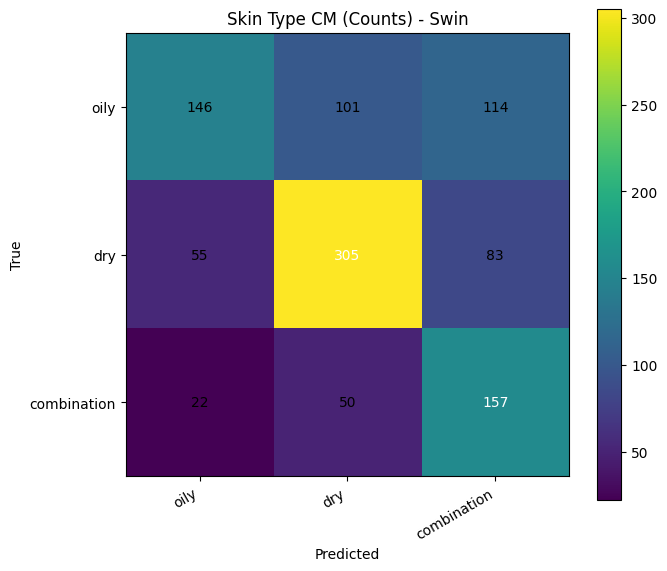

✅ Saved: /content/drive/MyDrive/SkinCare_AI_Component/results/confusion_matrices/skin_type_swin_confusion_matrix_counts.png


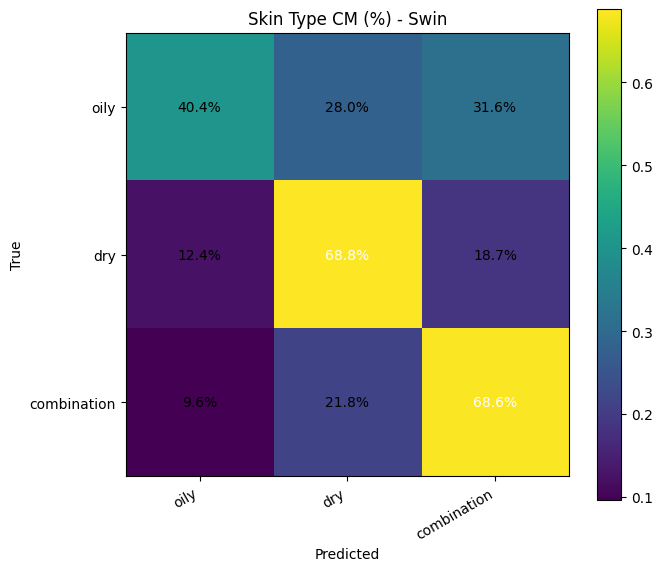

✅ Saved: /content/drive/MyDrive/SkinCare_AI_Component/results/confusion_matrices/skin_type_swin_confusion_matrix_percent.png


In [14]:
labels = [id_to_label[i] for i in range(num_classes)]
cm_np = np.array(cm)

# Counts CM
plt.figure(figsize=(7,6))
plt.imshow(cm_np)
plt.title("Skin Type CM (Counts) - Swin")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(range(num_classes), labels, rotation=30, ha="right")
plt.yticks(range(num_classes), labels)
plt.colorbar()
th = cm_np.max() * 0.5 if cm_np.size else 0
for i in range(num_classes):
    for j in range(num_classes):
        v = int(cm_np[i, j])
        plt.text(j, i, str(v), ha="center", va="center",
                 color=("white" if v > th else "black"))
plt.tight_layout()
plt.savefig(CM_OUT, dpi=250, bbox_inches="tight")
plt.show()
print("✅ Saved:", CM_OUT)

# Percent CM
cm_norm = cm_np / np.clip(cm_np.sum(axis=1, keepdims=True), 1, None)
plt.figure(figsize=(7,6))
plt.imshow(cm_norm)
plt.title("Skin Type CM (%) - Swin")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(range(num_classes), labels, rotation=30, ha="right")
plt.yticks(range(num_classes), labels)
plt.colorbar()
for i in range(num_classes):
    for j in range(num_classes):
        v = cm_norm[i, j] * 100
        plt.text(j, i, f"{v:.1f}%", ha="center", va="center",
                 color=("white" if v > 50 else "black"))
plt.tight_layout()
plt.savefig(CM_PCT_OUT, dpi=250, bbox_inches="tight")
plt.show()
print("✅ Saved:", CM_PCT_OUT)
